In this project we wanted to search the connection between the nutrition values on a food product to their price.
of course we know that there are more things that affects the price of a certain product, but in this project we'll look only at the nutrition values of the products

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as MSE

plt.style.use('seaborn')

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False)

In [3]:
df.head()

,Product_Name,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,Gilded_apple,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,lemon,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,Orange_in_the_juice_network,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,Avocado,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, Product_Name to Chlorophyll
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

In [6]:
prod = train_set.copy()

In [7]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
prod= prod.set_index('Product_Name')

In [8]:
for col in prod.columns:  
    prod[col] = pd.to_numeric(prod[col], errors='coerce')
prod = prod.fillna(0)
sts_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (df != 0).any(axis=0)]

In [9]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7668 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7668 non-null   float64
 1   Vitamin_B1                           7668 non-null   float64
 2   Vitamin_B6                           7668 non-null   float64
 3   Dietary_fiber                        7668 non-null   float64
 4   Folic_acid                           7668 non-null   float64
 5   energy                               7668 non-null   float64
 6   Proteins                             7668 non-null   float64
 7   Carbohydrates                        7668 non-null   float64
 8   Fats                                 7668 non-null   float64
 9   sodium                               7668 non-null   float64
 10  Vitamin_B3                           7668

### After a brief look at the cloumns we have, we pointed out a couple of things nedded to be done:
##### get rid of the unwanted units we have:
we want all the get rif of all the products that are not measured by 100_g or 1_kg (and delete the columns of these units).
afterwards, we need to unite the 100_g and 1_kg units (by deviding 1_kg by 10 we'll get the price for 100_g)
#### we'll check which columns left, and with them:
##### unite the columns:
- DHA_fatty_acid and DHA 
- Vitamin_A and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3 (they are reffering to the same thing: https://en.wikipedia.org/wiki/Niacin)
- DHA and EPA with DHA_+_EPA (?)

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [10]:
#first, we'll find the products without the wanted price units 
unwanted_units = prod[(prod['100_g']==0) & (prod['1_kg']==0)].index
print(unwanted_units)
#moreover, we'll check if there are any products with more than one wanted price units 
print(prod[(prod['100_g']!=0) & (prod['1_kg']!=0)].index)
#we'll notice that there are 807 products without the wanted price units and remove them
prod = prod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
prod['1_kg'] = prod['1_kg']/10
prod['price_per_100g'] = prod['1_kg'] + prod['100_g']
prod = prod.drop(['100_g' ,'1_kg'], axis=1)

Index(['Milk_in_a_3%_fat_carton', '5%_Organic_White_Wine_Vinegar',
       'Grape_seed_oil', 'Alpero_Almond_Coconut_Drink', 'Ice_snacks',
       '22%_gluten-free_coconut_cream', 'Thai_sauce_Pad_Thai',
       'Solgar_Super_Gala_300', 'Sweet_chili_sauce', 'Organic_coconut_oil',
       ...
       'Wholemeal_bun_case', 'Soy_drink_for_LS_Alpro',
       'Coffee-flavored_soy_drink', 'Alpro_Chocolate_Soy_Drink', 'Magnox_520',
       'Coconut_cream_20-22%', 'Sweet_and_sour_sauce',
       'Organic_apple_cider_vinegar_5%', 'Donuts_cocoa_cream_+_candies',
       'Natural_apple_juice'],
      dtype='object', name='Product_Name', length=807)
Index([], dtype='object', name='Product_Name')


In [11]:
#in order to reduce background noise, we decided to drop the columns in which there are less than 10 products with this feature
prod = prod.reset_index()
arr = np.array([])
col_droped = np.array([])
for col in prod.columns:
    if prod[col].astype(bool).sum(axis=0)<10: #all the features that less than precent of the products have
        arr = np.append(arr, prod[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col)
print(arr)
arr = set(arr) #all number of rows without duplicates
for i in arr:
    prod = prod.drop(i)
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero
prod = prod.set_index(['Product_Name'])


[2323. 4379. 4727. 1551. 6439. 1283. 1551. 2079.  586. 3500. 4984. 5605.
 6026. 5605.  797. 4383. 5508. 1027. 2198. 2432. 2536. 2902. 3961. 6195.
  385. 5599. 3010. 3010.  137.  597. 2313. 6139. 1060. 2682. 2861. 2901.
 2982. 4086. 5897. 4052. 4485. 2413. 3039. 5787. 5880. 6360. 6609.  832.
 1043. 3085. 3823. 3920. 2108. 5582.  294. 2877. 4831. 6771.  222. 1800.
 2427. 2697. 3343. 3526. 4311. 4399.  583. 3931. 5675.  583. 3931. 5675.]


In [12]:
all_dropped_collumns

Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Trans_fat', 'Acetic_acid',
       'Unsaturated', 'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA',
       'Chlorophyll'],
      dtype='object')

noticed that DHA, EPA and DHA_+_EPA collumns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- Vitamin_A and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- DHA and EPA with DHA_+_EPA (?)~~

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to scale the data in order to avoid any problems that might come with nutrition values that are measured by different units. We wanted to scale only the products and not the prices, so we splitted the prices from the nutrition values and then did the scaling. But before that we created another another train and test set based on how many products has values in each column, beacuse logicly, the nutrition values we have more can help us predict the price to a wider range of products.

In [13]:
products_notscaled = prod.drop("price_per_100g", axis=1)
prices = prod["price_per_100g"].copy()

### creating another data set:

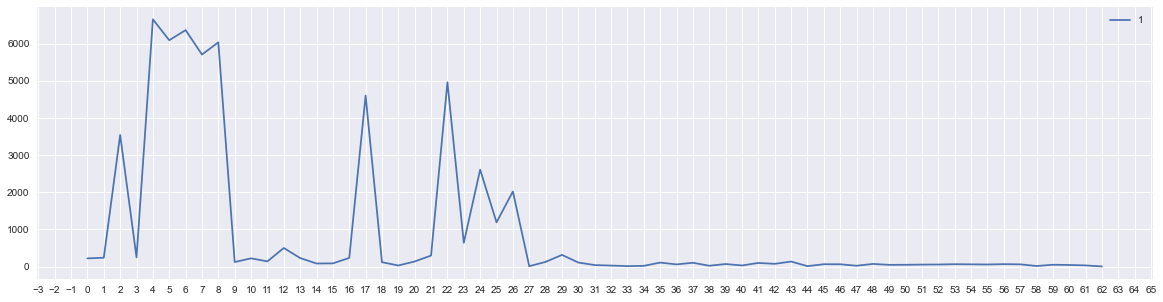

In [14]:
df_num = []
df_name = []
for col in products_notscaled.columns:
    df_num.append(int(products_notscaled[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Dynamically finds major tick positions
plta.gcf().set_size_inches(20, 5)
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 26, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns. (the reason we decided not to take specific columns is in order to prevent doing over fitting)

In the end, when we tried to run the models we decided what kind of filltering is the most worthy, and which features are better for predictions (what feature selection we should do)

In [15]:
products_notscaled2 = products_notscaled.iloc[:,2:26] 
prices2 = prices
products_notscaled2

,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,potassium,Vitamin_C,...,Magnesium,Carbohydrate_sugars,Vitamin_A,Dietary_fiber.1,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.00,89.00,0.80,9.20,6.30,17.5,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,3.30,0.00,0.00,0.0
Pasta_Perfecto_Casserole,1.60,0.00,160.00,0.00,0.00,0.00,0.0,0.0,0,0.0,...,0,1.4,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Whole_champignon_mushrooms,2.20,0.00,18.00,2.10,0.90,0.00,240.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Light_bread_from_whole_spelled,2.45,0.00,38.88,3.07,8.46,0.39,86.9,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.12,0.00,0.00,0.0
Baby_bite_flavored_vegetables,0.00,0.00,8.00,0.00,2.00,0.00,6.0,0.0,0,0.0,...,0,0.3,0.0,0.0,0.0,0.0,0.10,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,0.00,335.00,6.30,76.00,0.00,0.0,0.0,0,0.0,...,0,45.0,0.0,0.0,0.0,0.0,0.00,0.00,11.25,0.0
Slim_Delis_Multi-Grain_Milk,1.60,7.22,59.00,0.80,7.40,2.60,36.4,0.7,0,0.0,...,0,4.4,34.5,0.0,0.0,0.0,1.40,0.00,8.75,0.0
Chocolate_with_popsicles,0.00,0.00,516.00,8.10,58.00,27.00,117.0,0.0,0,0.0,...,0,57.0,0.0,0.0,0.0,0.0,16.50,0.00,14.25,0.0


In [16]:
scaler = StandardScaler()

scaler.fit(products_notscaled2)
productsarr2 = scaler.transform(products_notscaled2) #scaler returns numpy array
products2 = pd.DataFrame(productsarr2, index=products_notscaled2.index, columns=products_notscaled2.columns)




scaler.fit(products_notscaled)
productsarr = scaler.transform(products_notscaled) #scaler returns numpy array
products = pd.DataFrame(productsarr, index=products_notscaled.index, columns=products_notscaled.columns)

In [17]:
products

,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,...,selenium,copper,Taurine,Choline,Inositol,Lutein,Alpha_linolenic_acid,chlorine,Carnitine,Chloride
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,-0.017238,-0.073257,-0.577147,-0.041641,-1.000219,-0.423746,-0.728020,-0.424512,-0.193390,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Pasta_Perfecto_Casserole,-0.017238,-0.073257,-0.205797,-0.041641,-0.598461,-0.470633,-1.037156,-0.850453,-0.199576,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Whole_champignon_mushrooms,-0.017238,-0.073257,-0.066541,-0.041641,-1.401978,-0.347555,-1.006914,-0.850453,-0.114730,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Light_bread_from_whole_spelled,-0.017238,-0.073257,-0.008517,-0.041641,-1.283827,-0.290705,-0.752885,-0.824085,-0.168855,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Baby_bite_flavored_vegetables,-0.017238,-0.073257,-0.577147,-0.041641,-1.458564,-0.470633,-0.969952,-0.850453,-0.197455,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,-0.017238,-0.073257,-0.577147,-0.041641,0.391789,-0.101400,1.516572,-0.850453,-0.199576,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Slim_Delis_Multi-Grain_Milk,-0.016921,0.461902,-0.205797,0.040841,-1.169976,-0.423746,-0.788503,-0.674668,-0.186708,1.142092,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Chocolate_with_popsicles,-0.017238,-0.073257,-0.577147,-0.041641,1.415991,0.004094,0.911742,0.975009,-0.158214,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186


### uniting the desired columns:

In [18]:
def merge_two_columns(col1, col2, dataframe, index_col):
    if col1 in dataframe.columns and col2 in dataframe.columns:
        dataframe = dataframe.reset_index()
        row = 0
        for prod in dataframe[col1]:
            if (prod==0):
                if (dataframe.at[row , col2]!=0):
                    dataframe.at[row, col1] =  dataframe.at[row ,col2]  
            row = row+1
        dataframe = dataframe.drop([col2], axis = 1)
        dataframe = dataframe.set_index(index_col, drop=True)
        return dataframe
    else:
        return dataframe

In [19]:
products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', products, 'Product_Name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'Product_Name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'Product_Name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'Product_Name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'Product_Name')

### checking the correlations:

###### checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamoin is because they are often appears together in the same types of food. 

Hence, we'll try to find correlation between the different types of vitamin B, with the goal to unite them all under one column - Vitamin B group.

<AxesSubplot:>

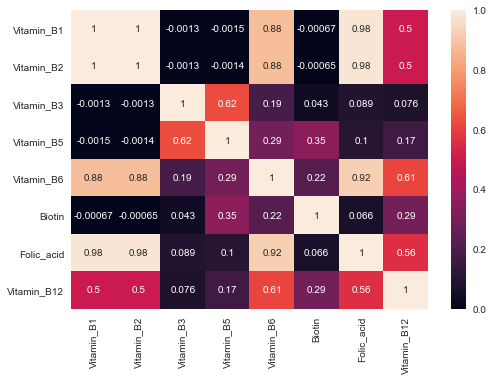

In [20]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = products.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the graph we're concluding that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6 or Vitamin_B9 (Folic_acid). 

We chosed them by the number of correlations that are about>=0.8 - by the bright orange colour (we didn't considered Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of these columns it will be by these criteria:
- the one with the most higher correlations
- the one with the least lower correlations
- the one with the most products in it (the Vitamin with the most products in a better representetive of the data)
- the one with the biggest correlation with column we want to predict - price_per_100g

In [21]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B3', 'Vitamin_B6', 'Folic_acid']
for rep in might_be_rep:
    column_1 = prices
    column_2 = products[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print(rep, ": number of products that has value: ", products[rep].astype(bool).sum(axis=0))
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  4
Vitamin_B1 : number of correlations that are below or equal 0.2:  3
Vitamin_B1 : number of products that has value:  6773
correlation between price_per_100g and  Vitamin_B1 :  0.017879922052323343
Vitamin_B3 : number of correlations that are greater than 0.8:  1
Vitamin_B3 : number of correlations that are below or equal 0.2:  6
Vitamin_B3 : number of products that has value:  6773
correlation between price_per_100g and  Vitamin_B3 :  -0.004888908958055477
Vitamin_B6 : number of correlations that are greater than 0.8:  4
Vitamin_B6 : number of correlations that are below or equal 0.2:  1
Vitamin_B6 : number of products that has value:  6773
correlation between price_per_100g and  Vitamin_B6 :  0.027527916996205982
Folic_acid : number of correlations that are greater than 0.8:  4
Folic_acid : number of correlations that are below or equal 0.2:  3
Folic_acid : number of products that has value:  6773
correlation between pr

By the two firet criteria we have putted first, it seems that the columns we should take as a representetive for the Vitamin B group is the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 5), and it has the smallest number of correlations that are below or equal 0.2 (which is 0). Although Vitamin_B6 dosen't have the biggest correlation between price_per_100g, it has the second biggest one, and the difference between them is not that big.

We thought that we had a problem - the fact that in the Vitamin_B6 there are only 265 products, which is less than 5 precent of our data (it's about three precents - dfprod has 7668 products).

So we tried a different approach - instead of choosing one column to be the representetive of all the group, we tried to merge between the difeerent Vitamin Bs. we gave more significance to Vitamin_B6 and the one's that were designated to be the representetives by this order: first Vitamin_B6, then Vitamin_B3 (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well). Afterwards there was be Vitamin_B9 (Folic_acid) with the next best correlation after the two before and the biggest number of correlations that are greater than 0.8 and then Vitamin_B1. Then there was be Vitamin_B12 ,who has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal 0.2. And last but not least were Biotin and Vitamin_B5 because we can see from the graph that the correlation between Biotin, Vitamin_B5 and the other of the Vitamins is low.

we tried a different combinations of the code that appears in the next window, but it seemed that anything we did made the correlation between the column we tried to create to the price_per_100g to get lower and lower.

In the End we decided to stick with the Vitamin_B6 as the representor of this group, except for Vitamin_B5, Biotin and Vitamin_B12 who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [22]:
products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B3','Folic_acid'], axis=1)

In [23]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B12'].sort_values(ascending=False)

Vitamin_B12                            1.000000
Partof_vitaminB                        0.612467
Biotin                                 0.294540
Vitamin_B5                             0.165142
Vitamin_D.                             0.148694
Nicotinamide                           0.140632
iron                                   0.139031
Vitamin_E.                             0.112690
Ascorbic_acid                          0.092588
Vitamin_C                              0.069211
Vitamin_A                              0.067969
Choline                                0.048198
Alpha_linolenic_acid                   0.046142
copper                                 0.042839
Inositol                               0.040652
Many_alcohols                          0.038361
iodine                                 0.033571
Vitamin_K.                             0.032884
From_the_carbohydrates_lactose         0.027185
Dietary_fiber                          0.024434
Proteins_(Albumin_|_Casein_40_|_60)    0

In [24]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B5'].sort_values(ascending=False)
#coudln't find the connection between copper and b5, bt found: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5                             1.000000
Biotin                                 0.351291
Nicotinamide                           0.332127
Partof_vitaminB                        0.291994
iron                                   0.236441
Ascorbic_acid                          0.226245
Inositol                               0.207285
Alpha_linolenic_acid                   0.205767
Vitamin_K.                             0.203478
copper                                 0.195340
Choline                                0.195189
iodine                                 0.173510
Vitamin_B12                            0.165142
calcium                                0.154370
From_the_carbohydrates_lactose         0.124368
Vitamin_C                              0.120856
Vitamin_E.                             0.099737
Dietary_fiber                          0.095609
Proteins_(Albumin_|_Casein_40_|_60)    0.089863
Vitamin_D.                             0.070437
Vitamin_A                              0

In [25]:
corr_matrix = products.corr()
corr_matrix['Biotin'].sort_values(ascending=False)
#the only connection found between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                                 1.000000
Vitamin_E.                             0.361419
Vitamin_B5                             0.351291
Vitamin_B12                            0.294540
Vitamin_C                              0.234850
Partof_vitaminB                        0.223963
Choline                                0.209858
Inositol                               0.205890
Alpha_linolenic_acid                   0.204358
copper                                 0.197393
Vitamin_K.                             0.196938
Ascorbic_acid                          0.183753
iodine                                 0.181673
Nicotinamide                           0.162341
From_the_carbohydrates_lactose         0.112928
Many_alcohols                          0.099389
Nucleotides                            0.098936
Proteins_(Albumin_|_Casein_40_|_60)    0.097003
Taurine                                0.090730
selenium                               0.089128
ARA_fatty_acid                         0

The highest correlation Vitamin_B12 has with anything is with the Partof_vitaminB column we made. Thus, we decided to can give up on this column as well(to be represented by the Partof_vitaminB column). Moreover, the highest correlations that Biotin and Vitamin_B5 has with any other feature is a week relationship (absolute value between 0.25 and 0.5).

Furthermore, because we such a succsess with choosing the representitive of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

In [26]:
products = products.drop(['Vitamin_B12'], axis = 1)
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','Vitamin_A','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5']
vitaminS = products.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
corrvl['Vitamin_K.'].sort_values(ascending=False)

Vitamin_K.         1.000000
Vitamin_C          0.429153
Vitamin_A          0.337444
Vitamin_D.         0.203926
Vitamin_B5         0.203478
Vitamin_E.         0.202357
Biotin             0.196938
Partof_vitaminB    0.066810
Name: Vitamin_K., dtype: float64

There isn't a particulater high correlation. There is a weak connection between them all, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### checking correlations between all the things that contains sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

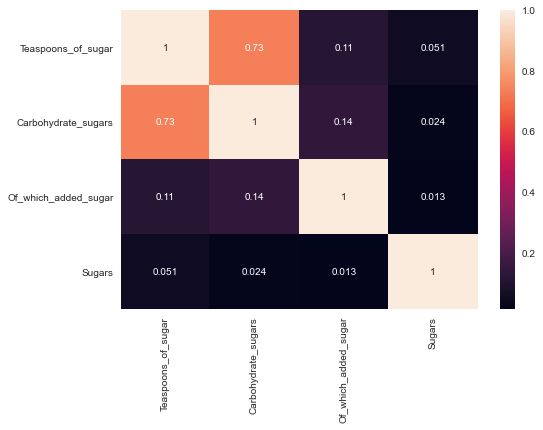

In [27]:
corr_matrix = products.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars'] #'From_sugars_to_organic_acids']
Sugars_matix = products.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph we can see that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Now, We'll check the correlation between Teaspoons_of_sugar, Carbohydrate_sugars and price_per_100g (in order to decide on which of the two columns we should give up), But before we'll decide to drop the Carbohydrate sugars (if it'll come to that) column we''ll check as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [28]:
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Teaspoons_of_sugar"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and Teaspoons_of_sugar ", correlation)
column_1 = products["Carbohydrate_sugars"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and the price per 100g ", correlation)
column_1 = products["Teaspoons_of_sugar"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation between Teaspoons of sugar and the price per 100g ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.4546421372962511
correlation between Carbohydrate_sugars and Teaspoons_of_sugar  0.7349214695187747
correlation between Carbohydrate_sugars and the price per 100g  0.02340660640197578
correlation between Teaspoons of sugar and the price per 100g  0.036414650513611965


The correlation between Carbohydrate_sugars and Teaspoons_of_sugar is indeed about 0.8 (0.73), and id higher than the correlation between Carbohydrates and Carbohydrate_sugars, which is due to the fact that in the labeling itself, some of the Carbohydrates are Carbohydrate_sugars (as we learn from LJ Amaral, R.D., a registered dietician in https://greatist.com/health/relationship-between-sugar-and-carbs#What-You-Need-to-Know-About-Sugar-and-Carbohydrates-). 

In every product there is a different amount of sugar, and thus the correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [29]:
products = products.drop(['Carbohydrate_sugars'], axis=1)

###### checking correlations between energy and the rest of the nutrition values:

In [30]:
corr_matrix = products.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False))

energy                                 1.000000
Fats                                   0.755120
Carbohydrates                          0.437101
Teaspoons_of_sugar                     0.311993
Dietary_fiber                          0.228599
iron                                   0.142828
Proteins                               0.135402
Cholesterol                            0.095639
Of_which_saturated_fat                 0.085372
Trans_fatty_acids                      0.073985
Saturated_fatty_acids                  0.050320
phosphorus                             0.031121
potassium                              0.024993
Of_which_added_sugar                   0.021964
Nicotinamide                           0.018753
Magnesium                              0.018697
Saturated_fat                          0.018256
calcium                                0.016837
Polyunsaturated_fat                    0.015029
zinc                                   0.011798
Vitamin_E.                             0

The strong correlation between "energy" and "Fats" is high, beacuse as we found at wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 

In [31]:
column_1 = products["energy"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = products["Fats"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)
products = products.drop(['energy'], axis=1) #the correlation with Fats is higher. thus, we'll drop the energy column

correlation with energy  0.03627238936618229
correlation with Fats  0.08294663316965706


###### checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fat acid. In they're compound, Linoleic_fatty_acid has 2 more hydrogen than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

In [32]:
'''Ft = ['Fats','Of_which_saturated_fat','Monounsaturated_fat','Polyunsaturated_fat','3_omega_fatty_acids',
             'Saturated_fat','Saturated_fatty_acids','Of_which_unsaturated_fat','6_omega_fatty_acids','Oleic_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid','AA_fatty_acid','Fat_without_trans']
Fats_list = products.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)'''

"Ft = ['Fats','Of_which_saturated_fat','Monounsaturated_fat','Polyunsaturated_fat','3_omega_fatty_acids',\n             'Saturated_fat','Saturated_fatty_acids','Of_which_unsaturated_fat','6_omega_fatty_acids','Oleic_fatty_acids'\n             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid','AA_fatty_acid','Fat_without_trans']\nFats_list = products.loc[:,Ft]\ncmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)\nfig, ax = plt.subplots(figsize=(12,12))\nsns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)\nsns.set(font_scale=1)"

we can see from graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further in the origins of ARA_fatty_acid. 

we found out that Linoleic acid, AA_fatty_acid, ARA_fatty_acid (apperaantly AA_fatty_acid and ARA_fatty_acid is the same fatty_acid) are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we descovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [33]:
if '6_omega_fatty_acids' in products.columns:
    products = merge_two_columns('6_omega_fatty_acids', 'AA_fatty_acid', products, 'Product_Name')
    products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'Product_Name')
    products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'Product_Name')
if '3_omega_fatty_acids' in products.columns:
    products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'Product_Name')
    products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'Product_Name')

In [34]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6773 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Dietary_fiber                        6773 non-null   float64
 1   Proteins                             6773 non-null   float64
 2   Carbohydrates                        6773 non-null   float64
 3   Fats                                 6773 non-null   float64
 4   sodium                               6773 non-null   float64
 5   potassium                            6773 non-null   float64
 6   Vitamin_C                            6773 non-null   float64
 7   iron                                 6773 non-null   float64
 8   Vitamin_K.                           6773 non-null   float64
 9   Vitamin_E.                           6773 non-null   float64
 10  Magnesium                            6773

In [35]:
#products.corr()

In [36]:
#corr_matrix = products.corr()
#sns.heatmap(corr_matrix) #in order to see if there's anything else worth checking

In [37]:
#print(corr_matrix["Vitamin_A"].sort_values(ascending=False).head(15))
#didn't found the connection between the features, but:
#found a connection between taurine on toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420
#found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/
#found a rate studies of destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/

In [38]:
#dfprod = dfprod.reset_index()
#products

After we accomplished all of our goals from the beginning and in that preapered the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measure RMSE.

RMSE means-



what we'll do to a new data coming into the system (such as the test set):
(first set two, then set 1):
and then we checked the dummy regressor score

In [39]:
def data_ready_version_2(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    
    
    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    
    dataw_notscaled2 = dataw.drop("price_per_100g", axis=1).iloc[:,2:26] 
    dataw_prices = dataw["price_per_100g"].copy()
    
    scaler.fit(products_notscaled2)
    dataw_scaledarr = scaler.fit_transform(dataw_notscaled2, products_notscaled2)
    dataw_scaled = pd.DataFrame(dataw_scaledarr, index=dataw_notscaled2.index, columns=dataw_notscaled2.columns)
    
    return dataw_scaled, dataw_prices

In [40]:
def data_ready_version_1(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_notscaled = dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    scaler.fit(products_notscaled)
    dataw_scaledarr = scaler.fit_transform(dataw_notscaled, products_notscaled)
    dataw_products = pd.DataFrame(dataw_scaledarr, index=dataw_notscaled.index, columns=dataw_notscaled.columns)
    
    dataw_products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Vitamin_B3','Folic_acid','Vitamin_B1','Vitamin_B12'
                              ,'Carbohydrate_sugars','energy'], axis=1)
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'AA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [41]:
def RMSE(real, prediction):
    return np.sqrt(MSE(real, prediction))

In [42]:
#test_set_prod2, test_set_prices2 = data_ready_version_2(test_set)

In [43]:
#test_set_prod1, test_set_prices1 = data_ready_version_1(test_set)

In [44]:
'''dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum2 = dummy_regr.predict(test_set_prod2)
mser = RMSE(test_set_prices2, predictdum2)
print( "mean squered error of " + str(mser)[:4])'''

'dummy_regr = DummyRegressor(strategy="mean")\ndummy_regr.fit(products, prices)\npredictdum2 = dummy_regr.predict(test_set_prod2)\nmser = RMSE(test_set_prices2, predictdum2)\nprint( "mean squered error of " + str(mser)[:4])'

In [45]:
'''dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum1 = dummy_regr.predict(test_set_prod1)
mser = RMSE(test_set_prices1, predictdum1)
print( "mean squered error of " + str(mser)[:4])'''

'dummy_regr = DummyRegressor(strategy="mean")\ndummy_regr.fit(products, prices)\npredictdum1 = dummy_regr.predict(test_set_prod1)\nmser = RMSE(test_set_prices1, predictdum1)\nprint( "mean squered error of " + str(mser)[:4])'

(it make sense that for both of the preperations the score of the dummy regressor is the same beacuse we did scaling so there is an even distribution, so the score of mean is the same). 

# end of data cleaning

# linear regression

In [46]:
def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

In [47]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
lin_reg = LinearRegression()

#products = products.drop(['wetness','ash'],axis=1)
print(products.shape, prices.shape)
predict1 = cross_val_predict(lin_reg, products, prices, cv=kf)
a=0
for i in predict1:
    print(i, a)
    a=a+1
print(maxN(predict1, 10))
rmse_linreg1 = RMSE(prices, predict1)
print(rmse_linreg1)

lin_reg = LinearRegression()
predict2 = cross_val_predict(lin_reg, products2, prices2, cv=kf)
rmse_linreg2 = RMSE(prices2, predict2)
print(rmse_linreg2)

(6773, 49) (6773,)
7.575355467190879 0
6.813979882069816 1
6.814630814174129 2
6.552129426047711 3
6.895372514990522 4
7.819612495023774 5
5.870079282309662 6
4.168817715444663 7
6.347916398468557 8
7.455330195006912 9
8.45112994928049 10
7.266291162292835 11
6.477805372951616 12
6.229129919805449 13
11.351851236299463 14
4.408662225898732 15
7.369664001647897 16
6.892011870100696 17
4.4165203460227715 18
9.671618596684528 19
8.148853780348915 20
6.6801751529812075 21
7.292327668937335 22
7.041188640241564 23
7.119589776172422 24
6.650899044074764 25
15.237934815934155 26
6.923101721697165 27
11.902664866276247 28
6.7851966317673655 29
6.087830703404093 30
9.01417919677125 31
12.644473082533972 32
7.01409199325871 33
8.593846758466839 34
6.59080598460981 35
9.237631471157137 36
6.909452611764803 37
6.710873993722536 38
6.585738629093598 39
4.739831354860474 40
7.303737214989903 41
8.900938482781452 42
6.291900091929442 43
5.6363365940506185 44
5.54872080441654 45
6.949380774283194 46
6

8.097920292572994 555
7.270671993006782 556
6.722630642826693 557
7.60654284170521 558
8.726423252989223 559
7.406127071977512 560
6.800155535438817 561
4.455143301101156 562
5.82009486232638 563
5.789880473184735 564
9.701827389112298 565
4.856130991930289 566
8.143228434219687 567
4.816182432116092 568
7.027200425026999 569
8.18852405897875 570
13.135560469209004 571
5.752867482548295 572
10.395567200277116 573
6.588705431153249 574
4.680428827915005 575
5.212027737652926 576
9.504218190456498 577
12.46334352168574 578
6.493928926930366 579
9.392160302726921 580
11.218928474688155 581
5.433614179873713 582
7.094696693852959 583
6.850035260827719 584
11.182044457190438 585
6.929308414297324 586
8.27670465228608 587
7.217158990061078 588
6.529995254721754 589
6.9876710222841005 590
6.988219616685686 591
4.915491717573923 592
5.83801038223339 593
7.858651993066798 594
8.965959364778426 595
6.526830251882854 596
10.507249994436279 597
9.322615943560168 598
6.49893807260997 599
6.29502480

10.392174285084074 1326
5.748135225592968 1327
6.798339177161483 1328
6.970869325215469 1329
7.141154169690425 1330
7.272825480253241 1331
6.888934552516069 1332
5.097301876287477 1333
9.470370656524185 1334
6.839280262540617 1335
6.651875223705352 1336
9.073627003187443 1337
6.306408751849675 1338
6.523504087641062 1339
7.044043767396075 1340
6.549586774489249 1341
8.31852499637388 1342
6.62351720602832 1343
7.75133702062491 1344
6.621055388232948 1345
7.526659324584722 1346
7.906709932261089 1347
6.566420835093931 1348
6.315022950872214 1349
18.85747671974396 1350
5.652962915070445 1351
6.861433477486792 1352
4.805463998076249 1353
6.97639924212657 1354
6.701890721838851 1355
7.480696084545082 1356
6.7874051103394555 1357
7.0423572833005466 1358
8.1871738404778 1359
5.881123434298718 1360
10.076186076715903 1361
9.248017545671695 1362
7.201727778040117 1363
6.286432489080194 1364
7.909236381114064 1365
4.694591743515642 1366
7.352900180569523 1367
6.897535192330932 1368
8.63368744970

7.232536686424293 2295
6.5033125593131125 2296
9.94045413462387 2297
6.75699693546489 2298
5.7775511911755 2299
5.643457870606019 2300
6.900066268642198 2301
8.273061967416645 2302
10.228921428868487 2303
10.368427428935984 2304
6.4629518564793695 2305
6.376368703014715 2306
9.130863605472596 2307
8.799721192567374 2308
6.176284820355473 2309
6.737971879594202 2310
5.493167818887783 2311
8.946657514282634 2312
5.273702485462942 2313
8.173194971101957 2314
8.75426542580633 2315
6.861515087634506 2316
5.7518739388814515 2317
9.705341002905346 2318
6.714559493325272 2319
7.1026285499208655 2320
7.597062135778185 2321
6.0679189512143825 2322
6.958281072102274 2323
6.478223048002957 2324
9.580654826423553 2325
7.253310694879198 2326
5.802550747532261 2327
3.9555290648248724 2328
5.893609485709098 2329
7.501388946468536 2330
4.623223267454375 2331
6.6018519898798065 2332
7.120148043680408 2333
6.407101496836833 2334
6.1296231677235395 2335
6.613189991962932 2336
8.127060078350738 2337
5.4477

7.231935487996004 3289
7.5570550649691945 3290
12.760240595739404 3291
8.893823799271722 3292
6.763767339053292 3293
6.98174269294576 3294
8.869332416009245 3295
6.48803040154677 3296
6.593082980292038 3297
22.14669125585893 3298
5.854329958499665 3299
6.311686417406938 3300
7.117195618121809 3301
5.765097292066667 3302
8.256352780922759 3303
7.19875669364981 3304
7.121854008355896 3305
7.058277062562675 3306
6.715023524967775 3307
6.595915703394832 3308
6.5331014235566816 3309
6.8655969527959035 3310
7.24929579805438 3311
5.779906054934974 3312
5.3314305987674 3313
5.990671872976888 3314
6.202440884663156 3315
22.561490615983264 3316
5.6630206011458935 3317
7.621082664514604 3318
6.199159416939832 3319
6.640650784572835 3320
6.933610203521162 3321
5.953518851976311 3322
6.2950219485775305 3323
6.932000652203908 3324
6.889597193669952 3325
3.931286058479405 3326
7.636257310227613 3327
7.5545146106826655 3328
7.717803820151743 3329
7.296957371579596 3330
9.423790101698737 3331
4.3139306

4.838514412282443 4260
6.735712694274197 4261
7.255832252393945 4262
6.357152496712562 4263
7.694725968781712 4264
7.5162505455093225 4265
6.736834170725909 4266
8.087509982130985 4267
6.8272734614611 4268
8.38512977662149 4269
7.331438321739715 4270
10.404570484728437 4271
4.704183037409573 4272
7.337717523108642 4273
15.433340060532995 4274
8.03736999400569 4275
6.7191190118993 4276
7.001430839856878 4277
8.514203272343833 4278
7.642480260812158 4279
6.790600415001491 4280
6.595741391346943 4281
8.175054666451002 4282
3.880265057097415 4283
5.629992329155691 4284
8.039890637170153 4285
6.829549613496353 4286
7.675477919023494 4287
9.371830094829805 4288
10.018462409138571 4289
7.731291414612393 4290
6.56870200399701 4291
6.871103693450042 4292
9.163519298438194 4293
6.668559327577164 4294
7.885442487962946 4295
4.539340790590901 4296
7.1135185237898835 4297
4.621264203362953 4298
7.338414940352336 4299
8.097915100242247 4300
6.791717698064847 4301
8.299179237739807 4302
8.69216633647

7.675432496997159 5227
6.007122933809526 5228
3.9163602992809956 5229
7.288413173934789 5230
7.450482901109813 5231
6.48229615694529 5232
6.840367637938108 5233
6.9711430395067255 5234
4.486618619518852 5235
6.126545441763586 5236
8.209633144425478 5237
7.355820849345277 5238
6.706692266048994 5239
6.683135410345447 5240
8.973561571976028 5241
6.872338814524872 5242
9.949983032309419 5243
7.493958220266719 5244
10.769189919798045 5245
7.07326234598764 5246
7.090625028588747 5247
8.059522807723638 5248
4.854670726332347 5249
6.876161265437735 5250
9.412320148018187 5251
5.881614566521831 5252
7.25755768543511 5253
6.822833723569236 5254
8.367713575510901 5255
12.252214511313403 5256
5.864237038136023 5257
8.03904223760959 5258
5.158739474630753 5259
7.1810897407844125 5260
6.885327849519245 5261
6.5383144267894355 5262
6.808763627450849 5263
5.92534485079316 5264
5.114053046349971 5265
7.076071293222489 5266
7.298570234976918 5267
6.711200815239169 5268
8.545928098605861 5269
7.83699857

8.261185808187822 6200
6.750015958881308 6201
6.513622180475951 6202
5.947498372819369 6203
9.228471447553197 6204
6.509806323533976 6205
9.690035981601458 6206
7.133197265684163 6207
6.728945567947447 6208
7.186265725840232 6209
4.754235642906094 6210
5.433727396830005 6211
7.305025649926594 6212
6.202620253577796 6213
6.255368207346426 6214
8.493550736449057 6215
5.645222055130532 6216
7.61855924062161 6217
6.102127114802008 6218
8.30117844807762 6219
7.073325571429018 6220
7.178977092635797 6221
3.680442859039112 6222
7.9505317097982 6223
7.166466190551147 6224
6.921160333031838 6225
7.777895209008632 6226
6.698010011593665 6227
6.475715016094447 6228
7.4387770976247625 6229
8.67913256309615 6230
6.730135046979713 6231
8.225515860418877 6232
7.769264525265851 6233
7.65175475765585 6234
5.766718888569579 6235
3.815313142229928 6236
5.2813358574032625 6237
8.136783981335636 6238
7.1486078565187015 6239
7.792284307398768 6240
5.335510656243603 6241
6.681317347351389 6242
6.997930626421

Feature: 0, Score: 0.08680
Feature: 1, Score: 0.04222
Feature: 2, Score: -0.83747
Feature: 3, Score: 0.78983
Feature: 4, Score: 0.20922
Feature: 5, Score: -0.12518
Feature: 6, Score: -0.24389
Feature: 7, Score: -0.17304
Feature: 8, Score: -0.22800
Feature: 9, Score: 0.36669
Feature: 10, Score: 0.03732
Feature: 11, Score: -0.14851
Feature: 12, Score: -0.01279
Feature: 13, Score: -0.21802
Feature: 14, Score: -0.01578
Feature: 15, Score: -0.03910
Feature: 16, Score: 0.68768
Feature: 17, Score: 0.02269
Feature: 18, Score: 0.12622
Feature: 19, Score: -0.04984
Feature: 20, Score: -0.17391
Feature: 21, Score: 1.35281
Feature: 22, Score: 0.00168
Feature: 23, Score: -0.09961
Feature: 24, Score: 0.09015
Feature: 25, Score: 0.02976
Feature: 26, Score: 0.35354
Feature: 27, Score: 0.08592
Feature: 28, Score: -0.00874
Feature: 29, Score: -0.15978
Feature: 30, Score: -0.30293
Feature: 31, Score: 0.19626
Feature: 32, Score: -0.09427
Feature: 33, Score: -0.11547
Feature: 34, Score: -0.06546
Feature: 35

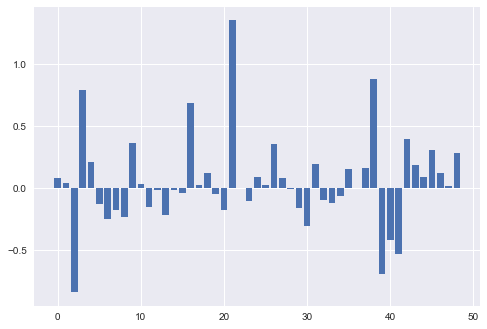

Feature: 2, Score: -0.83747
Feature: 3, Score: 0.78983
Feature: 9, Score: 0.36669
Feature: 16, Score: 0.68768
Feature: 21, Score: 1.35281
Feature: 26, Score: 0.35354
Feature: 30, Score: -0.30293
Feature: 38, Score: 0.87818
Feature: 39, Score: -0.69344
Feature: 40, Score: -0.42038
Feature: 41, Score: -0.53338
Feature: 42, Score: 0.39439
Feature: 45, Score: 0.31084


In [48]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products, prices)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.3:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [49]:
lin_reg = LinearRegression()
productsv = products.iloc[:,listm]
predict = cross_val_predict(lin_reg, productsv, prices, cv=kf)
rmse_linreg = RMSE(prices, predict)
print(rmse_linreg)

9.960763165413404


Feature: 0, Score: 0.06462
Feature: 1, Score: 2.23627
Feature: 2, Score: -0.63334
Feature: 3, Score: 0.02728
Feature: 4, Score: -0.31752
Feature: 5, Score: 1.24613
Feature: 6, Score: 0.13090
Feature: 7, Score: -0.16932
Feature: 8, Score: -0.22661
Feature: 9, Score: -0.27236
Feature: 10, Score: -0.22889
Feature: 11, Score: -1.98498
Feature: 12, Score: 0.13400
Feature: 13, Score: 0.19808
Feature: 14, Score: 0.00892
Feature: 15, Score: 0.39683
Feature: 16, Score: -0.04562
Feature: 17, Score: 0.24178
Feature: 18, Score: -0.01832
Feature: 19, Score: -0.25979
Feature: 20, Score: -0.01254
Feature: 21, Score: -0.02016
Feature: 22, Score: 0.26065
Feature: 23, Score: 0.12081


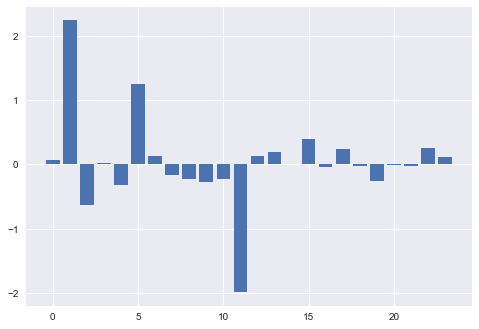

Feature: 0, Score: 0.06462
Feature: 1, Score: 2.23627
Feature: 2, Score: -0.63334
Feature: 3, Score: 0.02728
Feature: 4, Score: -0.31752
Feature: 5, Score: 1.24613
Feature: 6, Score: 0.13090
Feature: 7, Score: -0.16932
Feature: 8, Score: -0.22661
Feature: 9, Score: -0.27236
Feature: 10, Score: -0.22889
Feature: 11, Score: -1.98498
Feature: 12, Score: 0.13400
Feature: 13, Score: 0.19808
Feature: 14, Score: 0.00892
Feature: 15, Score: 0.39683
Feature: 16, Score: -0.04562
Feature: 17, Score: 0.24178
Feature: 18, Score: -0.01832
Feature: 19, Score: -0.25979
Feature: 20, Score: -0.01254
Feature: 21, Score: -0.02016
Feature: 22, Score: 0.26065
Feature: 23, Score: 0.12081


In [50]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products2, prices2)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.0000001:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [51]:
lin_reg = LinearRegression()
productsv2 = products.iloc[:,listm]
predict2 = cross_val_predict(lin_reg, productsv2, prices2, cv=kf)
rmse_linreg2 = RMSE(prices, predict2)
print(rmse_linreg2)

9.973986371101121


we can see that there are 2 outliers
tried to remove them but then there were 2 other outliers
couldn't find a reasonable explenation
it seems that linear regression is not a good model for this problem

# desicion tree regression

In [52]:
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products, prices, cv=kf)
rmse_score1 = RMSE(prices, predicttree1)
print(rmse_score1)

predicttree2 = cross_val_predict(tree_reg, products2, prices2, cv=kf)
rmse_score2 = RMSE(prices2, predicttree2)
print(rmse_score2)

8.81845037444541
9.938605592317492


Feature: 0, Score: 0.02431
Feature: 1, Score: 0.15230
Feature: 2, Score: 0.05841
Feature: 3, Score: 0.16064
Feature: 4, Score: 0.48248
Feature: 5, Score: 0.00056
Feature: 6, Score: 0.00007
Feature: 7, Score: 0.00144
Feature: 8, Score: 0.00031
Feature: 9, Score: 0.00082
Feature: 10, Score: 0.00030
Feature: 11, Score: 0.00138
Feature: 12, Score: 0.00005
Feature: 13, Score: 0.00076
Feature: 14, Score: 0.04852
Feature: 15, Score: 0.00148
Feature: 16, Score: 0.01293
Feature: 17, Score: 0.00439
Feature: 18, Score: 0.00779
Feature: 19, Score: 0.00031
Feature: 20, Score: 0.00015
Feature: 21, Score: 0.02759
Feature: 22, Score: 0.00011
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00022
Feature: 25, Score: 0.00001
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00018
Feature: 28, Score: 0.00005
Feature: 29, Score: 0.00034
Feature: 30, Score: 0.00012
Feature: 31, Score: 0.00021
Feature: 32, Score: 0.00007
Feature: 33, Score: 0.00009
Feature: 34, Score: 0.00010
Feature: 35, Score: 0.00347
Fe

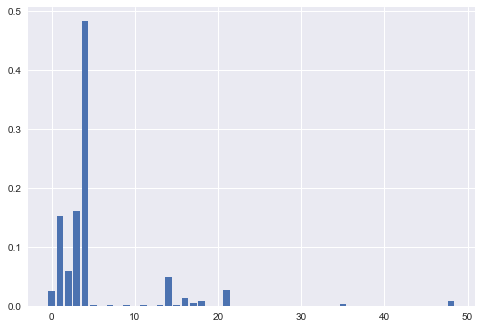

Feature: 0, Score: 0.02431
Feature: 1, Score: 0.15230
Feature: 2, Score: 0.05841
Feature: 3, Score: 0.16064
Feature: 4, Score: 0.48248
Feature: 7, Score: 0.00144
Feature: 11, Score: 0.00138
Feature: 14, Score: 0.04852
Feature: 15, Score: 0.00148
Feature: 16, Score: 0.01293
Feature: 17, Score: 0.00439
Feature: 18, Score: 0.00779
Feature: 21, Score: 0.02759
Feature: 35, Score: 0.00347
Feature: 48, Score: 0.00799


In [53]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products, prices)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi = []
for i,v in enumerate(importance):
    if v>0.001:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi.append(i)

In [54]:
products_3 = products.iloc[:,listi]
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products_3, prices, cv=kf)
rmse_score1 = RMSE(prices, predicttree1)
print(rmse_score1)

8.781306036210859


Feature: 0, Score: 0.02010
Feature: 1, Score: 0.00254
Feature: 2, Score: 0.07255
Feature: 3, Score: 0.29856
Feature: 4, Score: 0.03994
Feature: 5, Score: 0.02026
Feature: 6, Score: 0.41873
Feature: 7, Score: 0.00017
Feature: 8, Score: 0.00009
Feature: 9, Score: 0.00011
Feature: 10, Score: 0.00280
Feature: 11, Score: 0.00779
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00084
Feature: 14, Score: 0.00049
Feature: 15, Score: 0.04524
Feature: 16, Score: 0.00131
Feature: 17, Score: 0.00008
Feature: 18, Score: 0.00001
Feature: 19, Score: 0.00141
Feature: 20, Score: 0.04761
Feature: 21, Score: 0.00185
Feature: 22, Score: 0.01398
Feature: 23, Score: 0.00355


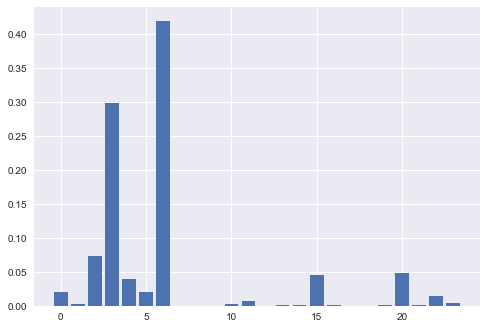

Feature: 0, Score: 0.02010
Feature: 1, Score: 0.00254
Feature: 2, Score: 0.07255
Feature: 3, Score: 0.29856
Feature: 4, Score: 0.03994
Feature: 5, Score: 0.02026
Feature: 6, Score: 0.41873
Feature: 10, Score: 0.00280
Feature: 11, Score: 0.00779
Feature: 15, Score: 0.04524
Feature: 16, Score: 0.00131
Feature: 19, Score: 0.00141
Feature: 20, Score: 0.04761
Feature: 21, Score: 0.00185
Feature: 22, Score: 0.01398
Feature: 23, Score: 0.00355


In [55]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products2, prices2)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi2 = []
for i,v in enumerate(importance):
    if v>0.0012:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi2.append(i)

In [56]:
products2_3 = products.iloc[:,listi2]
tree_reg = DecisionTreeRegressor()

predicttree2 = cross_val_predict(tree_reg, products2_3, prices2, cv=kf)
rmse_score2 = RMSE(prices2, predicttree2)
print(rmse_score2)

8.791017199934922


# random forest regressor

In [57]:
random_for = RandomForestRegressor()

prodicrfor1 = cross_val_predict(random_for, products, prices, cv=kf)
rmsefor = RMSE(prices, prodicrfor1)
print(rmsefor)

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2, prices2, cv=kf)
rmsefor2 = RMSE(prices, prodicrfor2)
print(rmsefor2)

7.190571358321829
7.3871091800562985


Feature: 0, Score: 0.03234
Feature: 1, Score: 0.00465
Feature: 2, Score: 0.10691
Feature: 3, Score: 0.07986
Feature: 4, Score: 0.05982
Feature: 5, Score: 0.04615
Feature: 6, Score: 0.45621
Feature: 7, Score: 0.00008
Feature: 8, Score: 0.00031
Feature: 9, Score: 0.00060
Feature: 10, Score: 0.00385
Feature: 11, Score: 0.00609
Feature: 12, Score: 0.00010
Feature: 13, Score: 0.00072
Feature: 14, Score: 0.00124
Feature: 15, Score: 0.07526
Feature: 16, Score: 0.00082
Feature: 17, Score: 0.00056
Feature: 18, Score: 0.00033
Feature: 19, Score: 0.00134
Feature: 20, Score: 0.07172
Feature: 21, Score: 0.00202
Feature: 22, Score: 0.04419
Feature: 23, Score: 0.00481


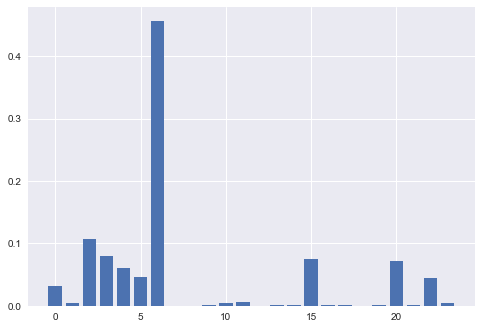

Feature: 2, Score: 0.10691
Feature: 6, Score: 0.45621


In [58]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products2, prices2)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
for i,v in enumerate(importance):
    if v>0.09:
        print('Feature: %0d, Score: %.5f' % (i,v))

In [59]:
v_2_2 = [0,2,3,4,5,6,10,11,14,15,19,20,21,22,23]
products2_2 = products.iloc[:,v_2_2]

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2_2, prices2, cv=kf)
rmsefor2 = RMSE(prices2, prodicrfor2)
print(rmsefor2)

7.180748857498412


Feature: 0, Score: 0.03579
Feature: 1, Score: 0.10028
Feature: 2, Score: 0.09014
Feature: 3, Score: 0.06093
Feature: 4, Score: 0.48018
Feature: 5, Score: 0.00051
Feature: 6, Score: 0.00023
Feature: 7, Score: 0.00310
Feature: 8, Score: 0.00007
Feature: 9, Score: 0.00088
Feature: 10, Score: 0.00147
Feature: 11, Score: 0.00075
Feature: 12, Score: 0.00019
Feature: 13, Score: 0.00084
Feature: 14, Score: 0.09931
Feature: 15, Score: 0.00660
Feature: 16, Score: 0.06373
Feature: 17, Score: 0.00485
Feature: 18, Score: 0.00992
Feature: 19, Score: 0.00026
Feature: 20, Score: 0.00018
Feature: 21, Score: 0.02917
Feature: 22, Score: 0.00005
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00013
Feature: 25, Score: 0.00014
Feature: 26, Score: 0.00019
Feature: 27, Score: 0.00014
Feature: 28, Score: 0.00022
Feature: 29, Score: 0.00010
Feature: 30, Score: 0.00043
Feature: 31, Score: 0.00018
Feature: 32, Score: 0.00013
Feature: 33, Score: 0.00011
Feature: 34, Score: 0.00001
Feature: 35, Score: 0.00290
Fe

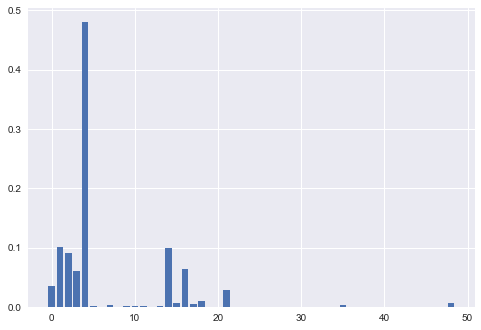

Feature: 0, Score: 0.03579
Feature: 1, Score: 0.10028
Feature: 2, Score: 0.09014
Feature: 3, Score: 0.06093
Feature: 4, Score: 0.48018
Feature: 14, Score: 0.09931
Feature: 16, Score: 0.06373
Feature: 21, Score: 0.02917


In [60]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products, prices)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
for i,v in enumerate(importance):
    if v>0.01:
        print('Feature: %0d, Score: %.5f' % (i,v))

In [61]:
v_2_1=[0,1,2,3,4,14,16,18,21]
products_2 = products.iloc[:,v_2_1]

random_for = RandomForestRegressor()
prodicrfor = cross_val_predict(random_for, products_2, prices, cv=kf)
rmsefor = RMSE(prices, prodicrfor)
print(rmsefor)

7.302927047988376


In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [10, 20, 30, 40, 50]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [10, 20, 30, 40, 50]},
 ]
grid_search = GridSearchCV(random_for, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(products, prices)
grid_search.best_params_

C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

{'bootstrap': False, 'max_features': 20, 'n_estimators': 3}